In [27]:
import pandas as pd
import numpy as np
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, mean_squared_error, roc_auc_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.cluster import KMeans
import cv2
import math

**Problem 1**

In [60]:
df = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")
df.set_index('customerID', inplace=True)
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

Create another instance of dataframe to test another preprocessing method

In [61]:
df2 = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")
df2.set_index('customerID', inplace=True)
df2['TotalCharges'] = pd.to_numeric(df2['TotalCharges'], errors='coerce')

In [110]:
X = df.drop(["Churn"], axis=1)
y = df["Churn"]

X2 = df2.drop(["Churn"], axis=1)
y2 = df2["Churn"]

In [111]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=16)
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.25, random_state=16)

For preprocessing, I performed One-Hot Encoding for all the categorical variables. I felt this was appropriate for the problem because if I simply replaced all values with 0,1,2,.. etc., this would suggest a natural ordering between the feature values which isn't true. For example, there is nothing that suggests Fiber Optic Internet Service is better than Cable. With One-Hot Encoding, dummy variables are created, with additional columns for each category, so that a 1 suggests the presence of that category, and 0 the absence. For the missing values in the numeric columns, for one instance,I chose to replace all the missing values with zeros. For the other instance, I decided to drop any columns with missing values. For replacing missing values with zeroes, this felt appropriate for the problem, since I noticed all the missing values only occured in the columns with numerical features. Since I do not want to lose effect that this feature has on whether or not the customer would leave, I chose to just replace the missing values with zero. For the instance where I dropped columns that contained missing values, I felt this would be a good approach because due to lack of domain knowledge, I did not want to erroneously fill in a value because it might introduce bias to my model and not be representative of the actual relationship between the variables.
In addition, I chose to normalize only the features that were not categorical. Since total charges were on a different scale and thus a lot larger than values for tenure, I decided that scaling all numeric columns would allow my model to perform better and prevent bias from some variables being in larger ranges.

In [112]:
#replace the yes and no values with 1 and 0
X_train = X_train.replace({'Yes': 1, 'No': 0})
X_test = X_test.replace({'Yes': 1, 'No': 0})
X_train2 = X_train2.replace({'Yes': 1, 'No': 0})
X_test2 = X_test2.replace({'Yes': 1, 'No': 0})
categorical_columns = [
    'gender', 'InternetService', 'MultipleLines',
    'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
    'TechSupport', 'StreamingTV', 'StreamingMovies',
    'Contract', 'PaymentMethod'
]

# One-hot encode categorical columns for each DataFrame
X_train = pd.get_dummies(X_train, columns=categorical_columns, drop_first=True)
X_test = pd.get_dummies(X_test, columns=categorical_columns, drop_first=True)
X_train2 = pd.get_dummies(X_train2, columns=categorical_columns, drop_first=True)
X_test2 = pd.get_dummies(X_test2, columns=categorical_columns, drop_first=True)

# Ensure all DataFrames have the same columns by reindexing
X_train, X_test = X_train.align(X_test, join='outer', axis=1, fill_value=0)
X_train2, X_test2 = X_train2.align(X_test2, join='outer', axis=1, fill_value=0)

#Transform false values to 0 and true values to 1 as a result of One-hot encoding
X_train[X_train.select_dtypes(include='bool').columns] = X_train.select_dtypes(include='bool').astype(int)
X_test[X_test.select_dtypes(include='bool').columns] = X_test.select_dtypes(include='bool').astype(int)
X_train2[X_train2.select_dtypes(include='bool').columns] = X_train2.select_dtypes(include='bool').astype(int)
X_test2[X_test2.select_dtypes(include='bool').columns] = X_test2.select_dtypes(include='bool').astype(int)


numerical_columns = [
    'tenure',
    'MonthlyCharges',
    'TotalCharges'
]

scaler = MinMaxScaler()

## for first data frame only, replace missing values with zeroes
for column in numerical_columns:
    X_train[column] = X_train[column].fillna(0)
    X_test[column] = X_test[column].fillna(0)
    ## for both data frames, scale the numerical columns
    X_train[numerical_columns] = scaler.fit_transform(X_train[numerical_columns])
    X_test[numerical_columns] = scaler.transform(X_test[numerical_columns])
    X_train2[numerical_columns] = scaler.fit_transform(X_train2[numerical_columns])
    X_test2[numerical_columns] = scaler.transform(X_test2[numerical_columns])



#for second data frame only, drop columns with missing values
X_train2.dropna(inplace=True, axis = 1)
X_test2.dropna(inplace=True, axis = 1)


##for both data frames, replace the yes and no values with 0 and 1
y_train = y_train.replace({'Yes': 1, 'No': 0})
y_train2 = y_train2.replace({'Yes': 1, 'No': 0})
y_test = y_test.replace({'Yes': 1, 'No': 0})
y_test2 = y_test2.replace({'Yes': 1, 'No': 0})




<ipython-input-112-0d6f6237fa7b>:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X_train = X_train.replace({'Yes': 1, 'No': 0})
<ipython-input-112-0d6f6237fa7b>:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X_test = X_test.replace({'Yes': 1, 'No': 0})
<ipython-input-112-0d6f6237fa7b>:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future

In [120]:
logreg = LogisticRegression(random_state=16, max_iter = 5000)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

logreg2 = LogisticRegression(random_state=16, max_iter = 5000)
logreg2.fit(X_train2, y_train2)
y_pred2 = logreg2.predict(X_test2)

In [121]:
print("Metrics for Missing Values Replaced with Zeroes")

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

precision = precision_score(y_test, y_pred)
print("Precision:", precision)

recall = recall_score(y_test, y_pred)
print("Recall (Sensitivity):", recall)

f1 = f1_score(y_test, y_pred)
print("F1-Score:", f1)

cv_scores = cross_val_score(logreg, X_train, y_train, cv=5)
mean_cv_score = cv_scores.mean()
print("Mean Cross-Validation Score:", mean_cv_score)

roc_auc = metrics.roc_auc_score(y_test, logreg.predict(X_test))
print("ROC-AUC Score:", roc_auc)

print("\n")
print("Metrics for Columns with Missing Values Dropped")

accuracy = accuracy_score(y_test2, y_pred2)
print("Accuracy:", accuracy)

precision = precision_score(y_test2, y_pred2)
print("Precision:", precision)

recall = recall_score(y_test2, y_pred2)
print("Recall (Sensitivity):", recall)

f1 = f1_score(y_test2, y_pred2)
print("F1-Score:", f1)

cv_scores = cross_val_score(logreg, X_train2, y_train2, cv=5)
mean_cv_score = cv_scores.mean()
print("Mean Cross-Validation Score:", mean_cv_score)

roc_auc = metrics.roc_auc_score(y_test2, logreg2.predict(X_test2))
print("ROC-AUC Score:", roc_auc)

Metrics for Missing Values Replaced with Zeroes
Accuracy: 0.7995457126632595
Precision: 0.6259168704156479
Recall (Sensitivity): 0.5614035087719298
F1-Score: 0.5919075144508671
Mean Cross-Validation Score: 0.8031055589002609
ROC-AUC Score: 0.7220810647307925


Metrics for Columns with Missing Values Dropped
Accuracy: 0.7989778534923339
Precision: 0.625615763546798
Recall (Sensitivity): 0.5570175438596491
F1-Score: 0.5893271461716937
Mean Cross-Validation Score: 0.8019699119864683
ROC-AUC Score: 0.7202712240371042


In [122]:
bayes = GaussianNB()
bayes.fit(X_train, y_train)
y_pred = bayes.predict(X_test)

bayes2 = GaussianNB()
bayes2.fit(X_train2, y_train2)
y_pred2 = bayes2.predict(X_test2)

In [123]:
print("Metrics for Missing Values Replaced with Zeroes")

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

precision = precision_score(y_test, y_pred)
print("Precision:", precision)

recall = recall_score(y_test, y_pred)
print("Recall (Sensitivity):", recall)

f1 = f1_score(y_test, y_pred)
print("F1-Score:", f1)

cv_scores = cross_val_score(bayes, X_train, y_train, cv=5)
mean_cv_score = cv_scores.mean()
print("Mean Cross-Validation Score:", mean_cv_score)

roc_auc = metrics.roc_auc_score(y_test, bayes.predict(X_test))
print("ROC-AUC Score:", roc_auc)


print("\n")
print("Metrics for Columns with Missing Values Dropped")

accuracy = accuracy_score(y_test2, y_pred2)
print("Accuracy:", accuracy)

precision = precision_score(y_test2, y_pred2)
print("Precision:", precision)

recall = recall_score(y_test2, y_pred2)
print("Recall (Sensitivity):", recall)

f1 = f1_score(y_test2, y_pred2)
print("F1-Score:", f1)

cv_scores = cross_val_score(logreg, X_train2, y_train2, cv=5)
mean_cv_score = cv_scores.mean()
print("Mean Cross-Validation Score:", mean_cv_score)

roc_auc = metrics.roc_auc_score(y_test2, logreg2.predict(X_test2))
print("ROC-AUC Score:", roc_auc)

Metrics for Missing Values Replaced with Zeroes
Accuracy: 0.676320272572402
Precision: 0.43817787418655096
Recall (Sensitivity): 0.8859649122807017
F1-Score: 0.5863570391872278
Mean Cross-Validation Score: 0.6800480562483873
ROC-AUC Score: 0.7445150231901594


Metrics for Columns with Missing Values Dropped
Accuracy: 0.6655309483248154
Precision: 0.4291799787007455
Recall (Sensitivity): 0.8837719298245614
F1-Score: 0.5777777777777777
Mean Cross-Validation Score: 0.8019699119864683
ROC-AUC Score: 0.7202712240371042


**Model Comparison**
To first compare how different pre-processing methods affected the model performance, we see that for each model, it produced similar results. However, for the mean cross validation score in Naive Bayes, we received different values, which will be discussed further. For accuracy, the Logistic Regression model received an accuracy score of .79 and the Naive Bayes model received an accuracy score of .67. This means that when given the predictors, the Logistic Regression model did a better of job of predicting a customer as one who would leave the service and they did, or a customer as one who would not leave the service and they did not (true positive and true negatives). For precision, the Logistic Regression model also showed a higher precision with .635 (as opposed to the Naive Bayes model's precision of .456) which shows the percentage of churns that were correctly predicted. Since Naive Bayes model has a precision of less than half, that means it had more false positive cases (predicting a churn when there wasn't one), than true positives (predicting a churn and the customer did leave the service). For recall, the Naive Bayes model had a better score of .842. This means that this model had a higher amount of true positives (predicting a churn and there was one), than false negatives (predicting a customer would not leave, but they did). The Logistic Regression model had a slightly better F1 score, with .5986 as opposed to the Naive Bayes' model of .592, but both are not very high. Since the F1 score is a combination of how good the precision and recall was, since the Logistic Regression model had a better precision, but the Naive Bayes had a better recall, this makes sense why the F1 scores are pretty similar to each other. For the mean cross validation score of model, this aligned with the results from the accuracy, with the Logistic Regression model showing a better model accuracy. The mean cross validation score in the Naive Bayes model provided surprising results in terms of the differences in how they were pre-processed. The model that dropped columns with missing values had a mean cross validation score of around .80, while the model for missing values replaced with zeroes had a mean cross validation score of .70. This may mean that when columns with missing values are dropped, it is able to perform better on different subsets of the data. The mean cross validation scores for the Logistic Regression model were similar for the two different pre-processing methods, around .80. In addition, the ROC AUC score tells how well a model does at distinguishing between positive and negative classes. The two models had a similar ROC AUC score of around 70%. Based off of this, the Logistic Regression model is more suited for this dataset due to the higher accuracy, but the user should be mindful that it will predict a high amount of false negatives. In addition, the Logistic Regression model had a higher mean cross-validation score than the Naive Bayes model. Since the mean cross-validation score is calculated from different splits on the data, it is probably a better indicator of how the model will perform on the data, rather than any one of the other metrics alone.


In [132]:
## Look at LogReg Coefficients to compare magnitudes of impact
coefficients = logreg.coef_[0]
coef_df = pd.DataFrame(zip(X_train.columns, coefficients), columns=['Feature', 'Coefficient'])
#print(coef_df.sort_values(by='Coefficient', ascending=False))

#To interpret the Naive Bayes model
# Look at mean values for each feature and their associated class probabilities
feature_means = bayes.theta_  # Shape (n_classes, n_features)
feature_summary = pd.DataFrame({
    'Feature': X_train.columns,
    'Means (Class 0)': feature_means[0],
    'Means (Class 1)': feature_means[1],

})

#print(feature_summary)

**Insights Gained**
Since the Logistic Regression from the two different pre-processing steps had similar performance metrics, I will only look at the coefficients for one of them. The magnitude of a coefficient is often a good indicator for the effect it had on the log odds of the outcome, the customer churn in this case. For the Logistic Regression model, the "Total Charges" and "Internet Service - Fiber Optic" variables had the biggest impact on increasing the log odds chances of a customer leaving the service. This means further investigation should be done to see if total charges can be reduced to lower the chances of them leaving the service and also why Fiber Optic Internet Service customers are most dissatisfied."Tenure" and the "Contract" variable had the biggest impact on decreasing the log odds of a customer leaving the service. The tenure and contract variables makes sense, as the longer a customer has stayed with Telco, the less likely they are to leave. Since "Total Charges" was dropped in the second preprocessing instance, upon further investigation to the coefficients for that model, it looks the exact same just missing the total charges variable.
From the Naive Bayes model, I chose to see the mean for the feature in the yes and no classes for churn. The results from this aligned with the results from the Logistic Regression model, where higher means for TotalCharges were associated with the customers who did leave the service.

**Problem 2**

In [133]:
img = cv2.imread('test_image.png')
height, width, channels = np.shape(img)
pixels = img.reshape(height * width, channels)

After getting the centroids from using the kmeans algorithm from sci-kit learn, I then calculated the euclidean distance between each pixel and the centroids to choose which color to assign that pixel to. I felt that Euclidean distance was an appropriate measure because since these are all on the same scales for the different values of RGB.

In [135]:
def img_kmeans(k, img):
  height, width, channels = np.shape(img)
  pixels = img.reshape(height * width, channels)
  kmeans = KMeans(n_clusters = k)
  kmeans.fit(pixels)
  colors = kmeans.cluster_centers_.astype(int)
  new = np.empty_like(img)

  for i in range(width):
    for j in range(height):
      pixel = img[j][i]
      #calculate this distance with each centroid
      newValue = colors[0]
      min_distance = math.inf
      for centroid in colors:
        euclidean = np.linalg.norm(centroid - pixel)
        if euclidean < min_distance:
          newValue = centroid
          min_distance = euclidean
      new[j][i] = newValue # Assign a new value to the pixel

  return new


array([[[131, 173, 202],
        [131, 173, 202],
        [131, 173, 202],
        ...,
        [ 41,  47,  52],
        [ 41,  47,  52],
        [ 41,  47,  52]],

       [[131, 173, 202],
        [131, 173, 202],
        [131, 173, 202],
        ...,
        [ 41,  47,  52],
        [ 41,  47,  52],
        [ 41,  47,  52]],

       [[131, 173, 202],
        [131, 173, 202],
        [131, 173, 202],
        ...,
        [ 41,  47,  52],
        [ 41,  47,  52],
        [ 41,  47,  52]],

       ...,

       [[ 41,  47,  52],
        [ 41,  47,  52],
        [ 41,  47,  52],
        ...,
        [ 41,  47,  52],
        [ 41,  47,  52],
        [ 41,  47,  52]],

       [[ 41,  47,  52],
        [ 41,  47,  52],
        [ 41,  47,  52],
        ...,
        [ 41,  47,  52],
        [ 41,  47,  52],
        [ 41,  47,  52]],

       [[ 41,  47,  52],
        [ 41,  47,  52],
        [ 41,  47,  52],
        ...,
        [ 41,  47,  52],
        [ 41,  47,  52],
        [ 41,  47,  52]]], dtype=uint8)
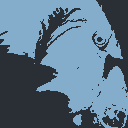

In [141]:
img = cv2.imread('test_image.png')
new = img_kmeans(2, img)
cv2.imwrite('new_image.png', new)
new

In [137]:
from skimage.metrics import structural_similarity as ssim

In [138]:
err = [0] * 20
img = cv2.imread('test_image.png')
for k in range(1,21):
  new = img_kmeans(k, img)
  similarity = ssim(img, new, win_size = 3, multichannel = True)
  err[k-1] = similarity






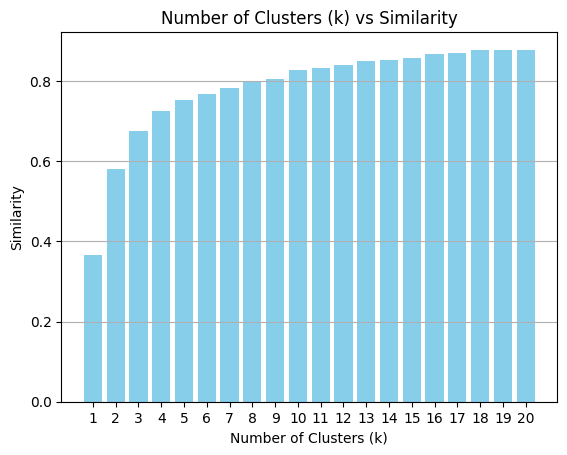

In [139]:
import numpy as np
import matplotlib.pyplot as plt


k_values = list(range(1, 21))

plt.bar(k_values, err, color='skyblue')
plt.title('Number of Clusters (k) vs Similarity')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Similarity')
plt.xticks(k_values)
plt.grid(axis='y')


plt.show()

To experiment with different values of k, I decided to use structural similarity from skimage.metrics to evaluate how similar the compressed image is to the original image. This function computes the similarities between luminance, constrast, and structure which all contribute to the way we perceive images. The values for ssim range between -1 and 1, with -1 represeting perfect dissimilarity and 1 being basically identical. We see that as we increase the number of clusters, there initially is a huge jump, but then the increase in similarity starts to taper off. It is still becoming closer to 1, but not much of a difference. For this problem, I would say around 10 clusters is enough. Since the original test image does not have a huge variety of colors, 10 clusters would be enough to represent the image well.